# Job Sequencing Problem with Integer Lengths
Here we show how to solve the job sequencing problems with integer lengths using OpenJij, [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/), and ommx-openjij-adapter. This problem is also mentioned in 6.3. Job Sequencing with Integer Lengths in [Lucas, 2014, "Ising formulations of many NP problems"](https://doi.org/10.3389/fphy.2014.00005).

## Overview of the Job Sequencing Problem with Integer Lengths

We consider several computers and tasks with integer lengths (i.e., task 1 takes one hour to execute on a computer, task 2 takes three hours, and so on).
When allocating these tasks to multiple computers to execute, the question is what combinations can be used to distribute the execution time of the computers without creating bias.
We can obtain a leveled solution by minimizing the largest value.

### Example

As an example of this problem, consider the following situation.

> Here are 10 tasks and 3 computers. 
> The length of each of the 10 tasks is 1, 2, ..., 10.
> Our goal is to assign these tasks to the computers and minimize the maximum amount of time the tasks take.
> In this case, one of the optimal solution is $\{1, 2, 7, 8\}, \{3, 4, 5, 6\}$ and $\{9, 10\}$, whose maximum execution time of computers is 19.

![](../../../assets/integer_jobs_01_en.png)

### Mathematical Model
Next, we introduce $N$ tasks $\{0, 1, ..., N-1\}$ and list of the execution time $\boldsymbol{L} = \{L_0, L_1, ..., L_{N-1}\}$. 
Given $M$ computers, the total execution time of the $j$ th computer to perform its assigned tasks is $A_j = \sum_{i \in V_j} L_i$ where $V_j$ is a set of assigned tasks to the $j$ th computer. Note that $A_j = \sum_i L_i x_{ij}$.
Finally, let us denote $x_{i, j}$ to be a binary variable which is 1 if the $i$ th task is assigned to the $j$ th computer, and 0 otherwise.

#### Constraint
Each task must be performed on one computer; for example, task 3 is not allowed to be executed on both computers 1 and 2. Also, it is not allowed that there is no computer that handles task 3.

$$
\nonumber
\sum_{j=0}^{M-1} x_{i, j} = 1 \quad (\forall i \in \{ 0, 1, \dots, N-1 \})
$$(1)

#### Objective Function
We consider the execution time of the $0$ th computer as the reference and minimize the difference between that and others.
This reduces the execution time variability and the tasks are distributed equally.

$$
\min \quad \sum_{j=1}^{M-1} (A_0 - A_j)^2
$$(2)



## Modeling by JijModeling

Next, we show an implementation using JijModeling.
We first define variables for the mathematical model described above.

In [5]:
import jijmodeling as jm


# defin variables
L = jm.Placeholder('L', ndim=1)
N = L.len_at(0, latex="N")
M = jm.Placeholder('M')
x = jm.BinaryVar('x', shape=(N, M))
i = jm.Element('i', (0, N))
j = jm.Element('j', (0, M))

`L` is a one-dimensional array representing the execution time of each task.
`N` denotes the number of tasks, and `M` is the number of computers.
We define a two-dimensional binary variables `x`, and we set the subscripts `i` and `j` used in the mathematical model.

### Constraint

We implement the constraint in equation (1) as follows:

In [6]:
# set problem
problem = jm.Problem('Integer Jobs')
# set constraint: job must be executed using a certain node
problem += jm.Constraint('onehot', x[i, :].sum()==1, forall=i)

### Objective Function


In [7]:
# set objective function: minimize difference between node 0 and others
A_0 = jm.sum(i, L[i]*x[i, 0])
A_j = jm.sum(i, L[i]*x[i, j])
problem += jm.sum((j, j!=0), (A_0 - A_j) ** 2)
problem

### Instance

Here we set the execution time of each job and the number of computers. We use the same values from the example mentioned.

In [8]:
# set a list of jobs
inst_L = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# set the number of Nodes
inst_M = 3
instance_data = {'L': inst_L, 'M': inst_M}

## Create Instance

In [10]:
instance = jm.Interpreter(instance_data).eval_problem(problem)

### Optimization by OpenJij

This time, we will use OpenJij's simulated annealing to solve the optimization problem.

In [13]:
import ommx_openjij_adapter as oj_ad
import openjij as oj

sampleset = oj_ad.OMMXOpenJijSAAdapter.sample(
    instance, uniform_penalty_weight=8.0, num_reads=100
)


From the results thus obtained, we can see how the task execution is distributed.

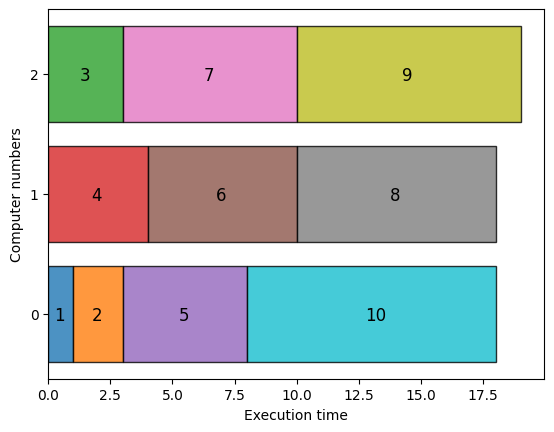

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x_result = sampleset.best_feasible_unrelaxed().extract_decision_variables("x")
# get the solution of the lowest index
x_indices = {k: v for k, v in x_result.items() if v > 0.5}
# get the instance information
L = instance_data["L"]
M = instance_data["M"]
# initialize execution time
exec_time = np.zeros(M, dtype=np.int64)
# compute summation of execution time each nodes
for i, j in x_indices:
    plt.barh(j, L[i], left=exec_time[j], ec="k", linewidth=1, alpha=0.8)
    plt.text(exec_time[j] + L[i] / 2.0 - 0.25, j - 0.05, str(i + 1), fontsize=12)
    exec_time[j] += L[i]
plt.yticks(range(M))
plt.ylabel("Computer numbers")
plt.xlabel("Execution time")
plt.show()

With the above visualization, we obtain a graph where the execution times of three computers are approximately equal.
The maximum value is 19, as explained at the beginning.